# Categorical Variational Autoencoders with MNIST
An autoencoder where the latent code is a concatenation of several one-hot vectors.

- Based on the paper by Jang, Gu, & Poole: https://arxiv.org/abs/1611.01144
- And the tutorial in this blog post: http://blog.evjang.com/2016/11/tutorial-categorical-variational.html?m=1

In [1]:
import numpy as np
import tensorflow as tf

import sys
import time

import load_mnist

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

## Fetch and Read In Data

In [50]:
train_im, test_im, train_labels, test_labels = load_mnist.Datasets()

In [51]:
all_im = np.concatenate([train_im, test_im]).astype(np.float32) / float(train_im.max())

## The Gumbel Softmax Trick

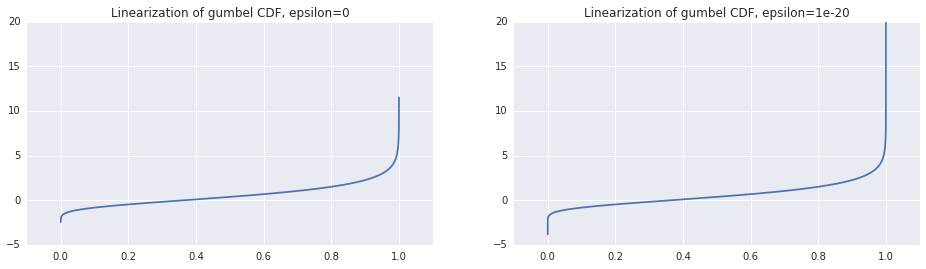

In [3]:
# A linearization of the Gumbel distribution's CDF
# Adding an epsilon prevents input of 0 from throwing an error.
def gumbel_linearization(x, epsilon):
    return -np.log(-np.log(x + epsilon) + epsilon)


figsize(16, 4)
space = np.linspace(0, 1, 100000)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(space, gumbel_linearization(space, epsilon=0))
ax2.plot(space, gumbel_linearization(space, epsilon=1e-20))
for ax, epsilon in zip((ax1, ax2), ("0", "1e-20")):
    ax.set_title("Linearization of gumbel CDF, epsilon=" + epsilon)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-5, 20)
plt.show()

In [21]:
def sample_gumbel(shape, epsilon=1e-20):
    uniform = tf.random_uniform(shape, minval=0, maxval=1)
    return -tf.log(-tf.log(uniform + epsilon) + epsilon)


def sample_gumbel_softmax(logits, temperature, epsilon=1e-20):
    return tf.nn.softmax(
        (logits + sample_gumbel(tf.shape(logits), epsilon)) / temperature)


def gumbel_softmax(logits, temperature, hard=False, epsilon=1e-20):
    y = sample_gumbel_softmax(logits, temperature, epsilon)
    if hard:
        y_hard = tf.cast(
            tf.equal(y, tf.reduce_max(y, 1, keep_dims=True)),
            y.dtype)
        # Ensures y_hard (which is undifferentiable )does not contribute
        # to the backward flow of the gradient. Basically: pass the
        # argmax forward, and the gradient of the softmax backward.
        y = tf.stop_gradient(y_hard - y) + y
    return y

## The Autoencoder

In [333]:
class GumbelSoftmaxVAE(object):
    
    def __init__(
            self, active_bits_per_encoding=30, one_hot_vector_length=10,
            img_shape=(28, 28), layer_sizes=(512, 256),
            epsilon=1e-20, sess=None):
        self.active_bits_per_encoding = active_bits_per_encoding
        self.one_hot_vector_length = one_hot_vector_length
        self.img_shape = img_shape
        self.layer_sizes = layer_sizes
        self.epsilon = epsilon
        
        # Network Initialization
        self.sess = sess or tf.InteractiveSession()
        self.build()
        self.sess.run(tf.initialize_all_variables())
        
        # Book-keeping
        self.iters = []
        self.losses = []
        self.elbos = []
        self.lrs = []
        self.taus = []
    
    def build(self):
        self.x = tf.placeholder(tf.float32, [None] + list(self.img_shape))
        
        # Encoder, q(y|x)
        x_flat = tf.reshape(self.x, [-1, np.prod(self.img_shape)])
        self.enc_layers = [x_flat]
        outsizes = list(self.layer_sizes) + [self.active_bits_per_encoding * self.one_hot_vector_length]
        for i, outsize in enumerate(outsizes):
            self.enc_layers.append(tf.contrib.layers.fully_connected(
                    self.enc_layers[-1],
                    outsize,
                    tf.nn.tanh if i < len(self.layer_sizes) else None))
        self.logits_y = tf.reshape(
            self.enc_layers[-1],
            [-1, self.one_hot_vector_length])
        self.q_y = tf.nn.softmax(self.logits_y)
        self.log_q_y = tf.log(self.q_y + self.epsilon)
                
        # Decoder
        self.tau = tf.placeholder(tf.float32, [], name="temperature")
        sample = tf.reshape(
            gumbel_softmax(self.logits_y, self.tau, hard=False),
            [-1, self.active_bits_per_encoding * self.one_hot_vector_length])
        self.dec_layers = [sample]
        outsizes = list(reversed(self.layer_sizes)) + [np.prod(self.img_shape)]
        for i, outsize in enumerate(outsizes):
            self.dec_layers.append(tf.contrib.layers.fully_connected(
                self.dec_layers[-1],
                outsize,
                tf.nn.tanh if i < len(self.layer_sizes) else None))
        self.output = tf.reshape(
            tf.nn.sigmoid(self.dec_layers[-1]),
            [-1] + list(self.img_shape))
        self.p_x = tf.contrib.distributions.Bernoulli(logits=self.dec_layers[-1])
        
        # Loss
        self.kl_divergence = tf.reduce_sum(
            tf.reshape(
                self.q_y * (self.log_q_y - tf.log(1.0 / self.one_hot_vector_length)),
                [-1, self.active_bits_per_encoding, self.one_hot_vector_length]),
            [1, 2])
        self.elbo = tf.reduce_sum(self.p_x.log_prob(x_flat), 1) - self.kl_divergence
        self.loss = -tf.reduce_mean(self.elbo)
        self.lr = tf.placeholder(np.float32, [])
        self.train = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
    
    def fit(
            self, images,
            tau=1.0, lr=0.001, verbose=False,
            batch_size=100, epochs=1, anneal_rate=0.00003, min_temp=0.5):
        ix = np.arange(images.shape[0])
        batches_per_epoch = ix.shape[0] / batch_size
        for ep in np.arange(epochs):
            if verbose:
                print "Starting epoch {}".format(ep)
            np.random.shuffle(ix)
            for b in np.arange(batches_per_epoch):
                i = (batches_per_epoch * ep) + b
                start = b * batch_size
                stop = start + batch_size
                this_tau = np.maximum(tau * np.exp(-anneal_rate * i), min_temp)
                _, loss, elbo = self.sess.run(
                    [self.train, self.loss, self.elbo],
                    feed_dict={
                        self.x: images[ix[start:stop]],
                        self.tau: this_tau,
                        self.lr: lr})
                self.iters.append(i)
                self.losses.append(loss)
                self.elbos.append(elbo)
                self.lrs.append(lr)
                self.taus.append(this_tau)
                if i % 1000 == 1:
                    lr *= 0.9
    
    def predict(self, images):
        return self.sess.run(
            [self.output],
            feed_dict={
                self.x: images,
                self.tau: 0.0001})[0]
    
    def show_reconstructions(self, images):
        reconst = self.predict(images)
        figsize(3, 1.5 * len(images))
        _, axs = plt.subplots(len(images), 2)
        axs_orig, axs_reconst = axs.T
        for axo, axr, imo, imr in zip(axs_orig, axs_reconst, images, reconst):
            axo.imshow(imo)
            axr.imshow(imr)
            [ax.set_axis_off() for ax in (axo, axr)]
        plt.show()
    
    def make_latent_code(self):
        one_hot = np.zeros(self.one_hot_vector_length * self.active_bits_per_encoding)
        active = np.random.randint(0, self.active_bits_per_encoding, self.one_hot_vector_length)
        offsets = np.arange(0, 10 * self.one_hot_vector_length, 10)
        one_hot[active + offsets] = 1
        return one_hot

    def generate(self, n):
        latent_codes = np.vstack(
            [self.make_latent_code() for _ in np.arange(n)])
        return self.sess.run(
            [self.output],
            feed_dict={
                self.dec_layers[0]: latent_codes})[0]

    def show_generated(self, n):
        gen = self.generate(n)
        figsize(15, 1.5 * np.ceil(n / 10.0))
        _, axs = plt.subplots(int(np.ceil(n / 10.0)), 10)
        axs = axs.flatten()
        for ax, im in zip(axs, gen):
            ax.imshow(im)
            ax.set_axis_off()
        plt.show()
        
    def training_report(self):
        figsize(16, 6)
        
        # Loss
        losses = np.array(self.losses)
        plt.plot(np.arange(losses.shape[0]), losses)
        plt.fill_between(
            np.arange(losses.shape[0]),
            -np.min(gsvae.elbos, axis=1), -np.max(gsvae.elbos, axis=1),
            alpha=0.3, linewidth=0)
        plt.xlabel("Batch")
        plt.ylabel("Batch Min, Max, and Mean Loss")
        plt.title("Elbo Loss by Training Iteration")
        plt.show()
        
        # Tau
        plt.plot(np.arange(len(self.taus)), self.taus)
        plt.xlabel("Batch")
        plt.ylabel("Tau")
        plt.title("Gumbel Softmax Temperature Parameter by Training Iteration")
        plt.show()

## Training and Results

In [334]:
sess.close()
del sess
sess = tf.InteractiveSession()
gsvae = GumbelSoftmaxVAE(sess=sess)

In [335]:
gsvae.fit(all_im, epochs=5)

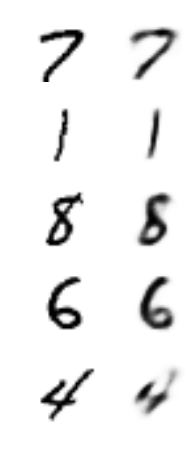

In [336]:
gsvae.show_reconstructions(all_im[123:128])

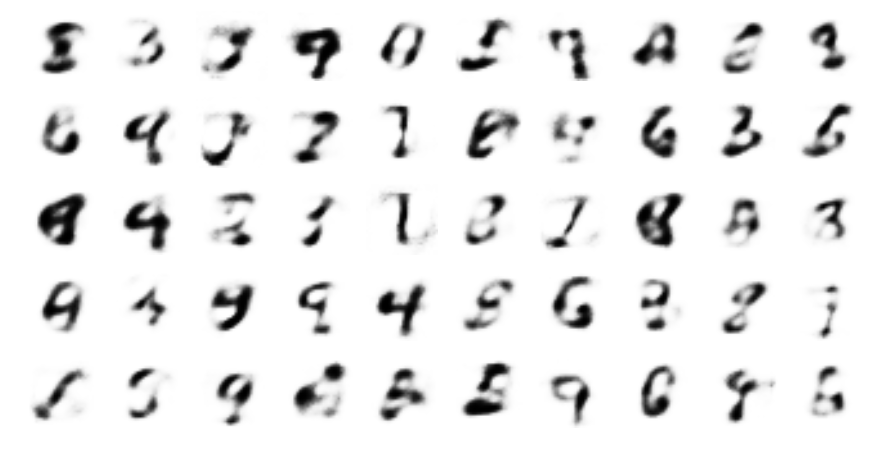

In [337]:
gsvae.show_generated(50)

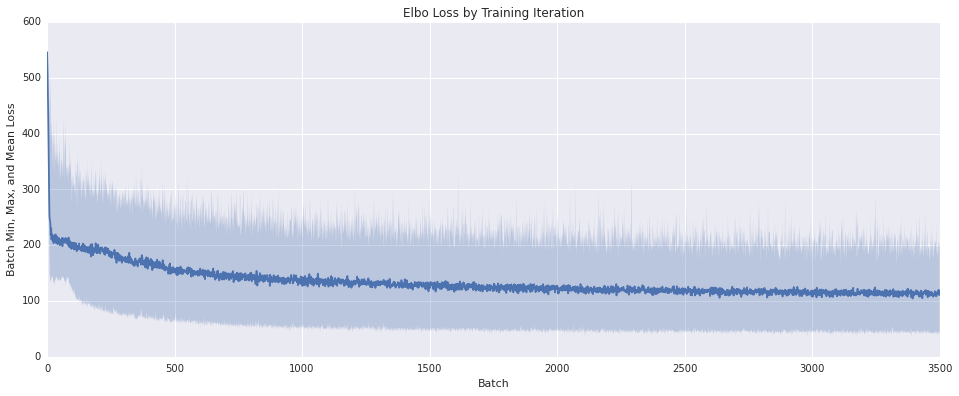

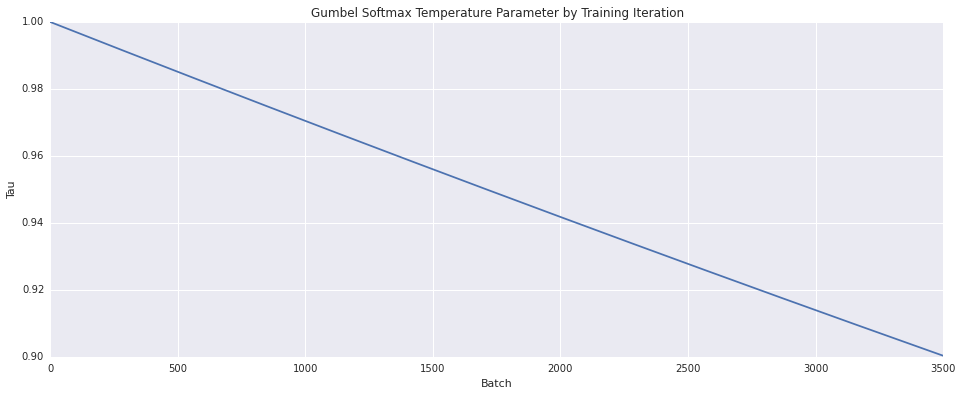

In [338]:
gsvae.training_report()